In [1]:
import msprime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import SVG
matplotlib.rcParams['figure.figsize'] = (8,5)

# Ancestry simulation

First we simulate the *trees*:

In [2]:
ts = msprime.sim_ancestry(
    samples=20, 
    sequence_length=1e5,
    recombination_rate=1e-8,
    population_size=4000,
    random_seed=456)
ts

We can look at them!

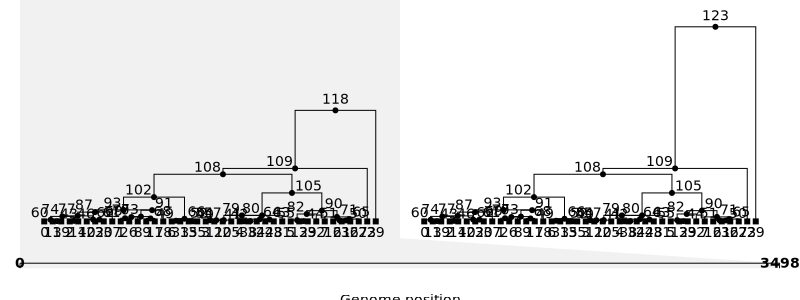

In [3]:
SVG(ts.draw_svg(size=(800,300), x_lim=[0, 3500]))

To get haplotypes we need to **add mutations** (more on this later):

In [4]:
ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=23)
ts

The mutations are red `x`'s:

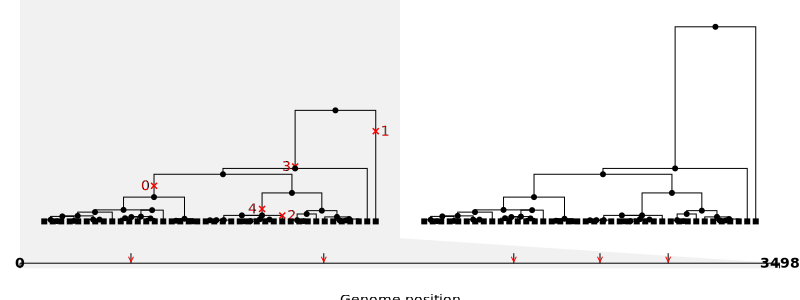

In [5]:
SVG(ts.draw_svg(size=(800,300), x_lim=[0, 3500], node_labels={}))

In [6]:
for h in ts.haplotypes():
    print(h)

CTGAGTTAGAGTGCAGTCTAAACAAGTTTGAGGTGACACGCAGTGCGTCCTCCTCCACGAATTTAGGCCTCTGGTATCTCCGCCTATAGAGA
CTGAGTTAGAGTGTAGTCTAAACAAGTTTGAGGTGCCACGCAGTGCTTCCTCCTCCACGAATTTAGGCCTCTGGTATCTCCGCCTATAGAGA
CTGAGTTAGAGTGCAGTCTCAACAAGATATCCCGCAGACTGAGTGCGGCCCCCTACACTAATTACGGCACCTAGTGTCCCCAGTTATAGAGA
GTGATTCAGAGTGCAGTCTAAACAAGTTTGAGGTGACGCGCAGTGCGTCCTCCTCCACGAATTTAGGCCTCTGGTATCTCCGCCTATAGAGA
GTGATTCAGAGTGCAGTCTAAGCAAGATATCCCGCAGACTGAGTGCGGCCCCCTACACTAATGACGGCACCAAGTGTCCCAGCCTACTAACC
GTGAGGTCGAGTGCAGTCTAAACAAGTTTGAGGTGACACGCAGTTCGTCCTCCTCCACGAATTTAGGCCTATGATATGTCCGCCTATAGAGA
CTGAGTTAGAGTGCAGTCAACACCCATCATCCGTCAGAGTGAGTGCGGCCTCCTCCTCGAATTTAGGCCTCTGGTAACTCCGCCAATAGAGA
GTGAGGTCGAGTGCAGTCTAAACAAGTTTGAGGTGACACGCAGTTCGTCCTCCTCCTCGAATTTAGGCCTCTGGTATCTCCGCCAATAGAGA
CTGAGTTAGAGTGCAGTCTAAACAAGTTTGAGGTGCCACGCAGTGCTTCCTCCTCCACGAACTTAGGCCTCTGGTATCTCCGCCTATAGAGA
CTGAGTTAGAGTGCAGTCTAAACAAGTTTGAGGTGCCACGCAGTGCTTCCTCCTCCACGAATTTAGGTCTCTGGTATCTCCGCCTATAGAGA
CTGAGTTAGAGTGCAGTCTAAACAAGTTTGAGGTGCCACGCGGTGAGGCGCTCAAAACGCATTTAGTCCC

# More looking at trees 

In [7]:
def plot_diversity(ts, mode='branch'):
    x = np.fromiter(ts.breakpoints(), dtype='float')
    pi = ts.diversity(windows='trees', mode=mode)
    fig, ax = plt.subplots()
    ax.plot(x[:-1] + np.diff(x)/2, pi)
    ax.set_xlabel("genome (bp)")
    ax.set_ylabel("mean diversity (generations)")
    return fig, ax

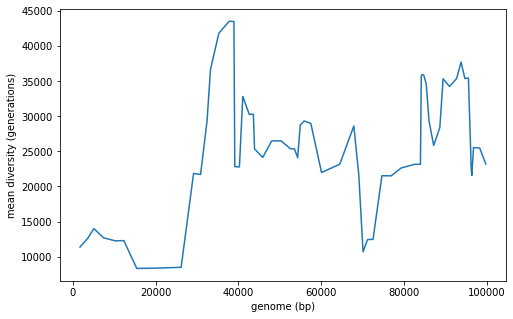

In [8]:
plot_diversity(ts);

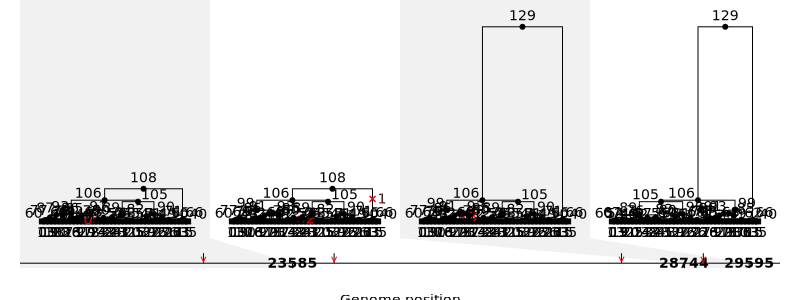

In [9]:
SVG(ts.draw_svg(size=(800,300), x_lim=[20000, 30000]))

# Recombination maps

Here's a nonuniform recombination map on a longer stretch of genome, with lower recombination rate on the right half:

In [10]:
recomb_map = msprime.RateMap(
    position=[0, 0.5e6, 1e6],
    rate=[1e-8, 1e-9])
ts = msprime.sim_ancestry(
    samples=20,
    population_size=4000,
    recombination_rate=recomb_map,
    random_seed=456,
)
ts

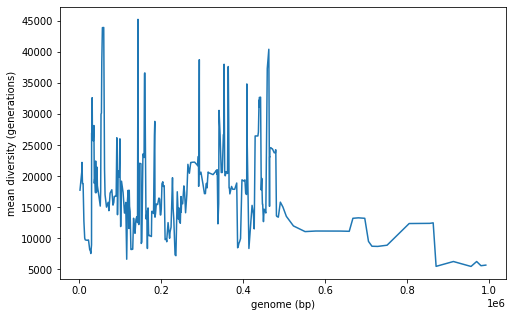

In [11]:
plot_diversity(ts);

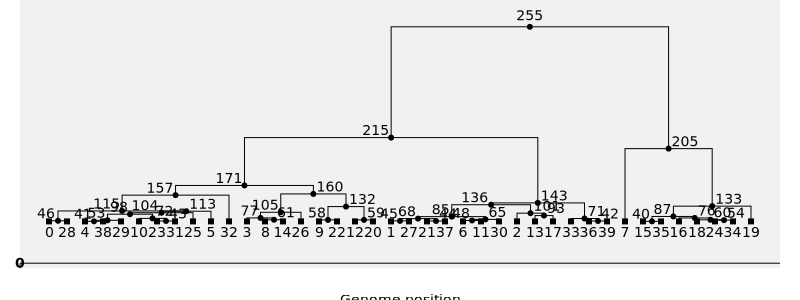

In [12]:
SVG(ts.draw_svg(size=(800,300), x_lim=[0, 1000]))

# Gene conversion

Adding gene conversion is easy, but produces many more trees:

In [13]:
ts = msprime.sim_ancestry(
    samples=20,
    population_size=4000,
    recombination_rate=recomb_map,
    gene_conversion_rate=1e-7,
    gene_conversion_tract_length=100,
    random_seed=123,
)
ts

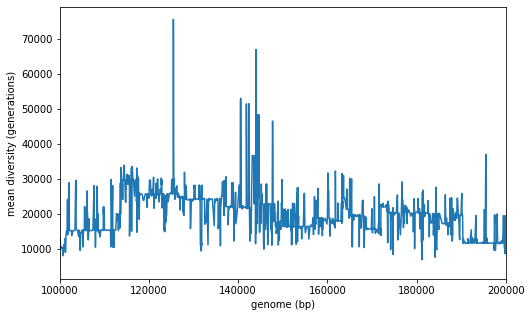

In [14]:
fig, ax = plot_diversity(ts)
ax.set_xlim([0.1e6, 0.2e6]);

Hm, let's zoom in on that peak?

In [15]:
t = ts.at(120000)
r = t.root
while ts.node(t.root).time < 70000:
    t.next()

print(t.interval)

Interval(left=125446.0, right=125549.0)


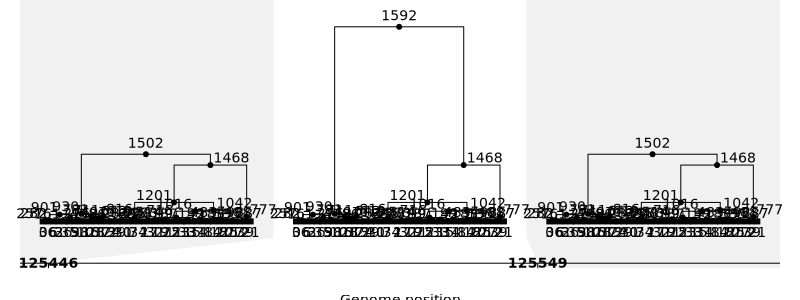

In [16]:
SVG(ts.draw_svg(size=(800,300), x_lim=[125440, 125600]))

# Demography

We can (and should!) use *names* when making demographic models!

In [17]:
demog = msprime.Demography()
demog.add_population(name='A', initial_size=2000)
demog.add_population(name='B', initial_size=5000)
demog.set_symmetric_migration_rate(
    populations=['A', 'B'],
    rate=1e-4)

ts = msprime.sim_ancestry(
    samples={'A': 10, 'B': 10},
    demography=demog,
    sequence_length=1e4,
    recombination_rate=1e-8,
)
ts

Here's the first tree, with nodes colored by population. Note the smaller population coalesces first, mostly.

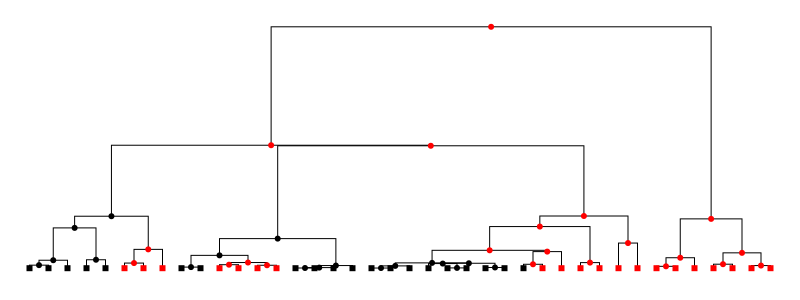

In [18]:
t = ts.first()
SVG(t.draw_svg(
    size=(800, 300),
    node_labels={},
    root_svg_attributes={"id": "treeA"},
    style="#treeA .p1.node > .sym {fill: red}"
))

# Back to mutations

We can choose from different mutation models, e.g. Felsenstein 1984's nucleotide model:

In [19]:
ts = msprime.sim_ancestry(
    samples={'A': 10, 'B': 10},
    demography=demog,
    sequence_length=1e7,
    recombination_rate=1e-8,
)

mut = msprime.F84(kappa=1.5)
mut_map = msprime.RateMap(
    position=[0, 5e6, 10e6],
    rate=[1e-9, 1e-8])
mts = msprime.sim_mutations(ts, model=mut, rate=mut_map)
mts

Here is density of segregating sites within each population, then across both:

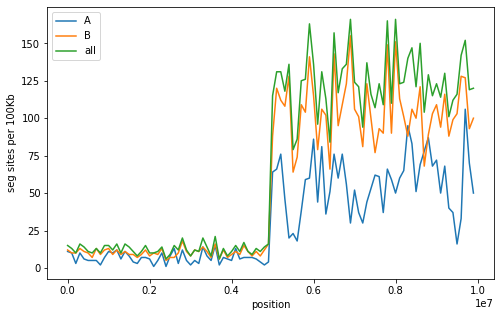

In [20]:
windows = np.linspace(0, mts.sequence_length, 101)
segsites = mts.segregating_sites(
    sample_sets=[mts.samples(0), mts.samples(1), mts.samples()],
    windows=windows, span_normalise=False
)

plt.plot(windows[:-1], segsites, label=['A', 'B', 'all'])
plt.xlabel('position')
plt.ylabel('seg sites per 100Kb')
plt.legend();

# Demography from a phylogeny

In [21]:
dem = msprime.Demography.from_species_tree(
    "((A:900,B:900)ab:100,C:1000)abc;",
    initial_size=1e3
)
samples = {"A": 4, "B": 4, "C": 4}
ts = msprime.sim_ancestry(
    samples,
    demography=dem,
    sequence_length=5e4,
    recombination_rate=1e-8,
    random_seed=1234
)
ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=7)

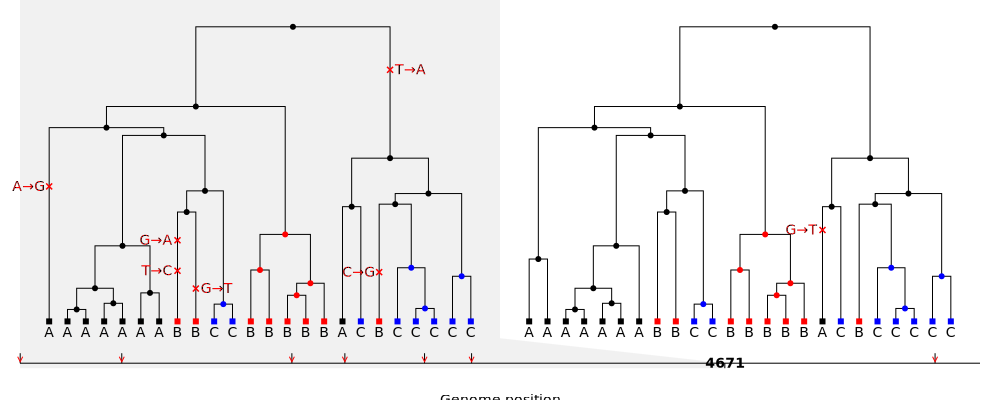

In [22]:
x_limits = [1000, 6000]

nd_labels = {}  # An array of labels for the nodes
for n in ts.nodes():
    # Set sample node labels from metadata. Here we use the population name, but you might want
    # to use the *individual* name instead, if the individuals in your tree sequence have names
    if n.is_sample():
        nd_labels[n.id] = ts.population(n.population).metadata["name"]

mut_labels = {}  # An array of labels for the mutations
for mut in ts.mutations():  # Make pretty labels showing the change in state
    site = ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = "{}→{}".format(prev, mut.derived_state)

SVG(ts.draw_svg(
        x_lim=x_limits,
        node_labels=nd_labels,
        mutation_labels=mut_labels,
        size=(1000, 400),
        root_svg_attributes={"id": "treeA"},
        style="#treeA .p1.node > .sym {fill: red}"
              "#treeA .p2.node > .sym {fill: blue}"
    ))


## a mutation matrix model

In [23]:
alleles = ["💩", "🎄", "🔥"]
model = msprime.MatrixMutationModel(
    alleles,
    root_distribution = [0.0, 1.0, 0.0],
    transition_matrix = [[0.0, 1.0, 0.0],
                         [0.0, 0.2, 0.8],
                         [1.0, 0.0, 0.0]]
)
ts = msprime.sim_ancestry(5, population_size=1e4, recombination_rate=1e-8, sequence_length=1000, random_seed=9)
mts = msprime.sim_mutations(ts, rate=5e-8, model=model, random_seed=1)

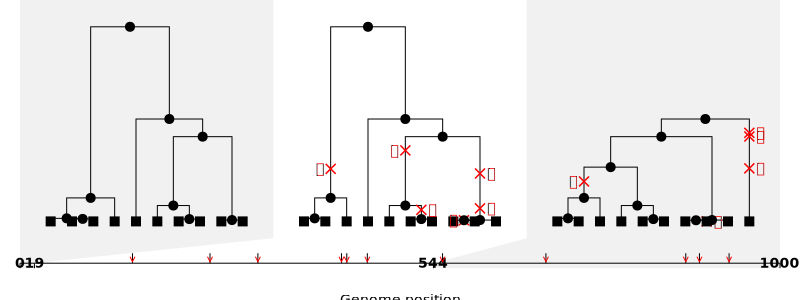

In [24]:
SVG(mts.draw_svg(
        size=(800,300),
        node_labels={},
        mutation_labels={m.id: m.derived_state for m in mts.mutations()},
        symbol_size=10,
    ))

# Sweeps

In [25]:
sweep_model = msprime.SweepGenicSelection(position=2.5e4,
    s=0.01, start_frequency=0.5e-4, end_frequency=0.99, dt=1e-6)
sts = msprime.sim_ancestry(9,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=1e4,
    recombination_rate=1e-8,
    sequence_length=5e4, random_seed=9,
)


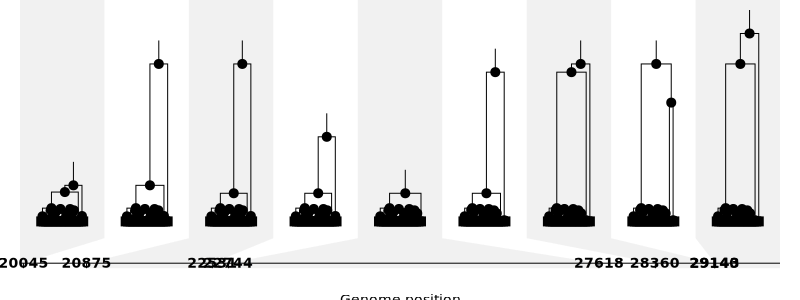

In [26]:
SVG(sts.draw_svg(
    size=(800,300),
    x_lim=[2e4, 3e4],
    node_labels={},
    symbol_size=10,
    force_root_branch=True,
))

Above we switched from the sweep model to the standard coalescent.
But we can do these steps separately!

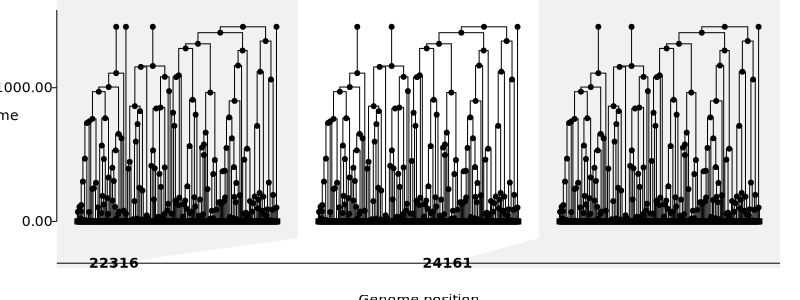

In [35]:
sweep_model = msprime.SweepGenicSelection(position=2.5e4,
    s=0.01, start_frequency=0.01, end_frequency=0.99, dt=1e-6)
ots = msprime.sim_ancestry(90,
    model=sweep_model,
    population_size=1e4,
    recombination_rate=1e-8,
    sequence_length=5e4, random_seed=9,
)
SVG(ots.draw_svg(
    x_lim=[2.2e4, 2.6e4],
    size=(800,300),
    node_labels={},
    y_axis=True,
    y_ticks=np.arange(0, 2500, 1000),
))

Now let's recapitate with a Beta coalescent:

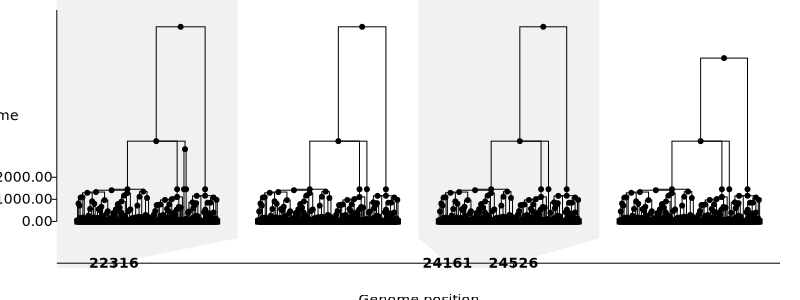

In [36]:
rts = msprime.sim_ancestry(
    initial_state=ots,
    model=msprime.BetaCoalescent(alpha=1.5),
    recombination_rate=1e-8,
    population_size=1e5,
    random_seed=10
)
SVG(rts.draw_svg(
    x_lim=[2.2e4, 2.6e4],
    size=(800, 300),
    node_labels={},
    y_axis=True,
    y_ticks=np.arange(0, 2500, 1000),
))

And, we can compare this to a pure Beta coalescent model:

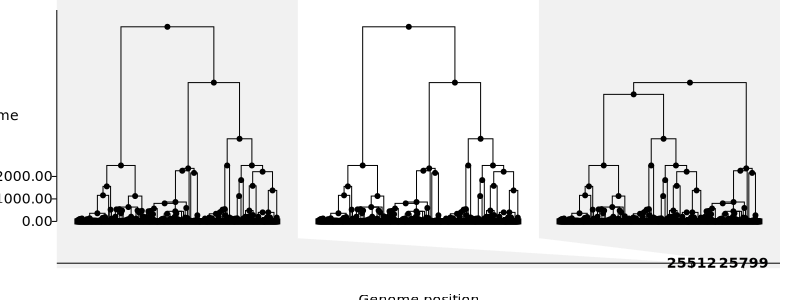

In [29]:
bts = msprime.sim_ancestry(90,
    model=msprime.BetaCoalescent(alpha=1.5),
    recombination_rate=1e-8,
    population_size=1e5,
    sequence_length=5e4,
    random_seed=10
)
SVG(bts.draw_svg(
    x_lim=[2.2e4, 2.6e4],
    size=(800, 300),
    node_labels={},
    y_axis=True,
    y_ticks=np.arange(0, 2500, 1000),
))

# SLiM

We can recapitate tree sequences from SLiM also:

In [30]:
slim_recipe = '''
initialize() {
   initializeTreeSeq();
   initializeMutationRate(1e-7);
   initializeMutationType("m1", 0.5, "f", 0.0);
   initializeGenomicElementType("g1", m1, 1.0);
   initializeGenomicElement(g1, 0, 1200000);
   initializeRecombinationRate(1e-8);
}
1 { sim.addSubpop("p1", 4); }
1: { sim.treeSeqRememberIndividuals(p1.individuals); }
12 late() { sim.treeSeqOutput("slim.trees"); }
'''
with open("small.slim", "w") as f:
    f.writelines(slim_recipe)

In [31]:
%%bash
slim -s 23 small.slim

// Initial random seed:
23

// RunInitializeCallbacks():
initializeTreeSeq();
initializeMutationRate(1e-07);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 1200000);
initializeRecombinationRate(1e-08);

// Starting run at generation <start>:
1 



#WARNING (SLiMSim::RunInitializeCallbacks): with tree-sequence recording enabled and a non-zero mutation rate, a neutral mutation type was defined and used; this is legal, but usually undesirable, since neutral mutations can be overlaid later using the tree-sequence information.


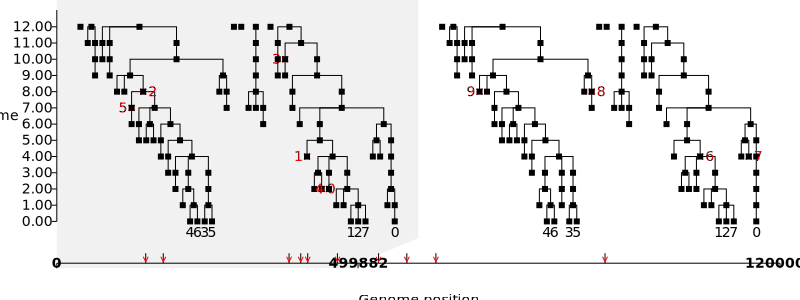

In [32]:
import pyslim
slim_ts = pyslim.load("slim.trees")
node_labels = {}
k = 0
for n in slim_ts.nodes():
    if n.time == 0.0:
        node_labels[n.id] = k
        k += 1
SVG(slim_ts.draw_svg(
    size=(800, 300),
    node_labels=node_labels,
    y_axis=True,
))

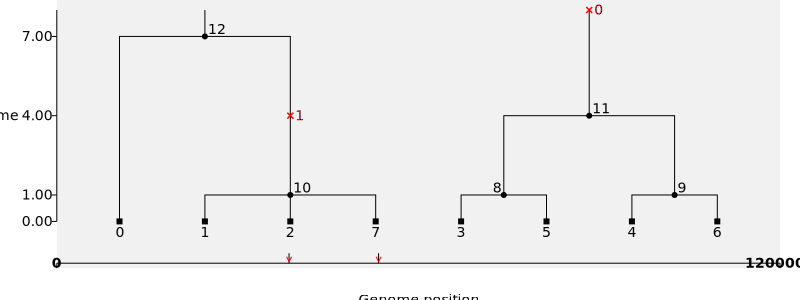

In [33]:
SVG(slim_ts.simplify(list(node_labels.keys())).draw_svg(
    size=(800, 300),
    y_axis=True,
))